In [656]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt

In [657]:
# collector_df = pd.read_csv('../data/qos/reports.csv')
# sender_df = pd.read_csv('../data/qos/latency_udp.csv')
# t = (200, 260)

# collector_df = pd.read_csv('../data/increasing/reports.csv')
# sender_df = pd.read_csv('../data/increasing/latency_udp.csv')
# t = (400, 450)

# collector_df = pd.read_csv('../data/constant/reports.csv')
# sender_df = pd.read_csv('../data/constant/latency_udp.csv')
# t = (400, 450)

# collector_df = pd.read_csv('../data/http/reports.csv')
# sender_df = pd.read_csv('../data/http/latency_http.csv')
# t = (1860, 1905)


# collector_df = pd.read_csv('../data/http2/reports.csv')
# sender_df = pd.read_csv('../data/http2/latency_http.csv')
# t = (165, 180)

# collector_df = pd.read_csv('../data/http3/reports.csv')
# sender_df = pd.read_csv('../data/http3/latency_http.csv')
# t = (200, 240)

collector_df = pd.read_csv('../data/new_http_udp1/reports.csv')
sender_df = pd.read_csv('../data/new_http_udp1/latency_http.csv')
t = (105, 120)


# collector_df = pd.read_csv('../data/new_http_tcp1/reports.csv')
# sender_df = pd.read_csv('../data/new_http_tcp1/latency_http.csv')
# t = (380, 400)


sender_df.columns = ['timestamp', 'latency', 'dropped']

sender_df['latency'] = sender_df['latency'].apply(lambda x: int(x * 1000))
collector_df['hop_latency'] = collector_df['hop_latency'].apply(lambda x: int(x / 1000))

sender_start = sender_df.iloc[0]['timestamp']
collector_start = collector_df.iloc[0]['collector_timestamp']
start = min(sender_start, collector_start)

collector_df['collector_timestamp'] -= start
sender_df['timestamp'] -= start

In [658]:
collector_df.head()

,collector_timestamp,flow_id,collection_id,src_ip,dst_ip,src_port,dst_port,protocol,seq_num,reporting_sw,...,egress_timestamp,hop_latency,ingress_timestamp,l1_egress_port_id,l1_ingress_port_id,l2_egress_port_id,l2_ingress_port_id,queue_occupancy,queue_occupancy_id,switch_id
0,1.340883,0,0,10.244.7.10,10.244.3.6,49456,8000,6,0,6,...,1716069563709291000,0,1716069563708684000,1,2,0,0,0,0,0
1,1.340883,0,0,10.244.7.10,10.244.3.6,49456,8000,6,0,6,...,1716069563710416000,0,1716069563710061000,3,1,0,0,0,0,1
2,1.340883,0,0,10.244.7.10,10.244.3.6,49456,8000,6,0,6,...,1716069563711448000,0,1716069563711030000,2,1,0,0,0,0,0
3,1.340883,0,0,10.244.7.10,10.244.3.6,49456,8000,6,0,6,...,1716069563712659000,0,1716069563712102000,2,1,0,0,0,0,0
4,1.340883,0,0,10.244.7.10,10.244.3.6,49456,8000,6,0,6,...,1716069563716258000,3,1716069563712659000,1,0,0,0,0,0,6


In [659]:
sender_df.head()

,timestamp,latency,dropped
0,0.000000,80,2
1,0.079941,79,3
2,0.159985,80,4
3,1.245502,1085,5
4,1.431825,186,5


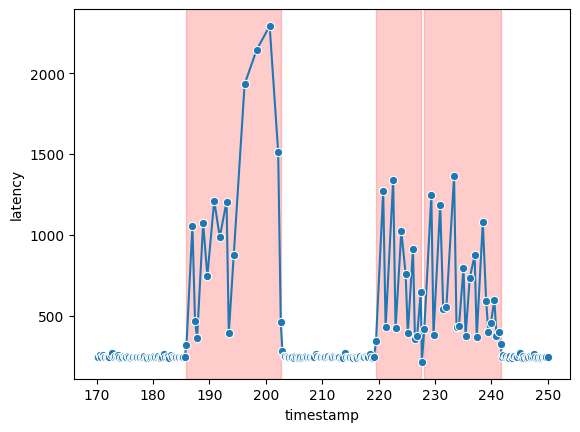

In [660]:
def compute_qos_violation_time_ranges(sender_df: pd.DataFrame, violation_threshold=400) -> list[tuple[float, float]]:
    violation_ranges = []
    start = None
    for i in range(len(sender_df)):
        is_violation = sender_df.iloc[i]['latency'] > violation_threshold
        if is_violation and start is None:
            start = i
        elif not is_violation and start is not None:
            if i - start > 1:
                violation_ranges.append([sender_df.iloc[start]['timestamp'], sender_df.iloc[i - 1]['timestamp']])
            start = None
    if start is not None and start < len(sender_df) - 1:
        violation_ranges.append([sender_df.iloc[start]['timestamp'], sender_df.iloc[len(sender_df) - 1]['timestamp']])

    return violation_ranges

def display_qos_violations(violation_ranges: list[tuple[float, float]], ax, delay=0, padding=0):
    for start, end in violation_ranges: 
        start = start - delay - padding
        end = end - delay + padding
        ax.axvspan(start, end, color='red', alpha=0.2)
    
def _test_show_qos_violations(sender_df: pd.DataFrame, collector_df: pd.DataFrame, violation_threshold=400, collector_x='collector_timestamp'):
    sdf = sender_df.copy()
    fig, ax = plt.subplots(1, 1)
    sns.lineplot(data=sdf, x='timestamp', y='latency', marker='o', ax=ax)
    violation_ranges = compute_qos_violation_time_ranges(sender_df, violation_threshold=300)
    display_qos_violations(violation_ranges, ax)

_test_show_qos_violations(sender_df[(sender_df['timestamp'] > 170) & (sender_df['timestamp'] < 250)], collector_df)

<Axes: xlabel='collector_timestamp', ylabel='hop_latency'>

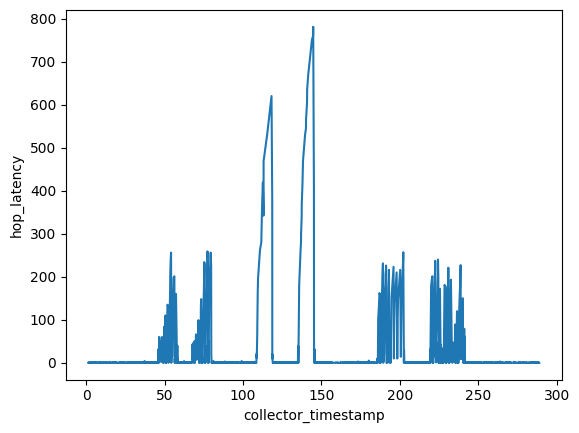

In [661]:
sns.lineplot(data=collector_df[(collector_df['switch_id']==1) & (collector_df['l1_egress_port_id']==3)], x='collector_timestamp', y='hop_latency')

<Axes: xlabel='collector_timestamp', ylabel='queue_occupancy'>

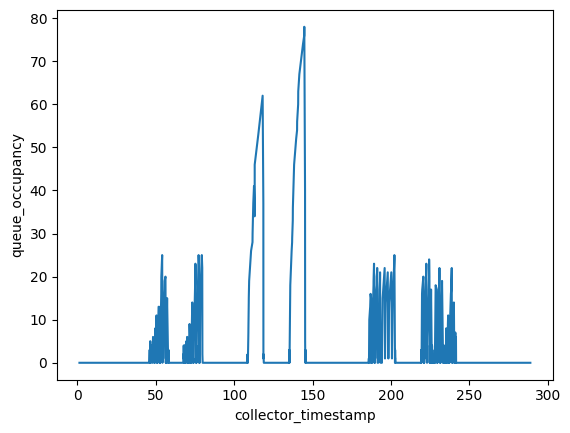

In [662]:
sns.lineplot(data=collector_df[(collector_df['switch_id']==1) & (collector_df['l1_egress_port_id']==3)], x='collector_timestamp', y='queue_occupancy')

<Axes: xlabel='timestamp', ylabel='latency'>

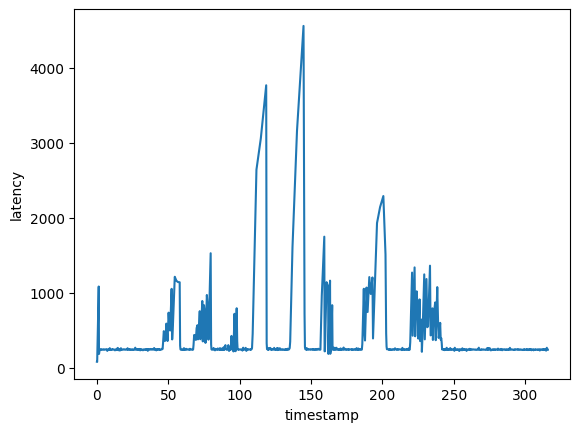

In [663]:
sns.lineplot(data=sender_df, x='timestamp', y='latency')

In [664]:
collector_df['port_key'] = collector_df.apply(lambda row: f'{row["switch_id"]}_{row["l1_egress_port_id"]}', axis=1)

In [665]:
collector_df['port_key'].unique()

array(['0_1', '1_3', '0_2', '6_1', '1_1', '0_3', '5_2', '8_1', '5_1'],
      dtype=object)

<Axes: xlabel='collector_timestamp', ylabel='hop_latency'>

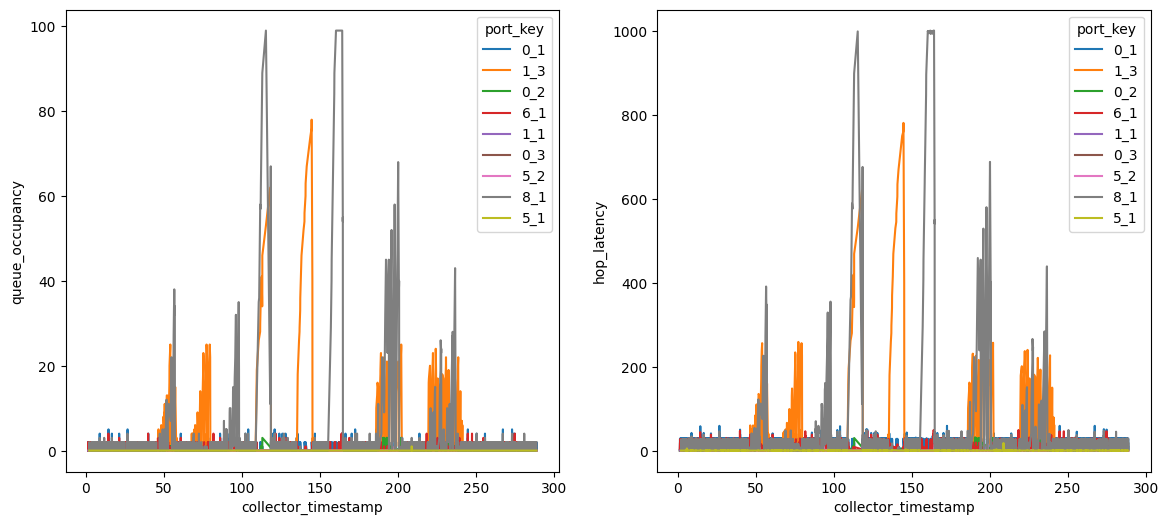

In [666]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
sns.lineplot(ax=ax[0], data=collector_df, x='collector_timestamp', y='queue_occupancy', hue='port_key', legend=True, estimator=None, n_boot=0)
sns.lineplot(ax=ax[1], data=collector_df, x='collector_timestamp', y='hop_latency', hue='port_key', legend=True, estimator=None, n_boot=0)

<Axes: xlabel='collector_timestamp', ylabel='hop_latency'>

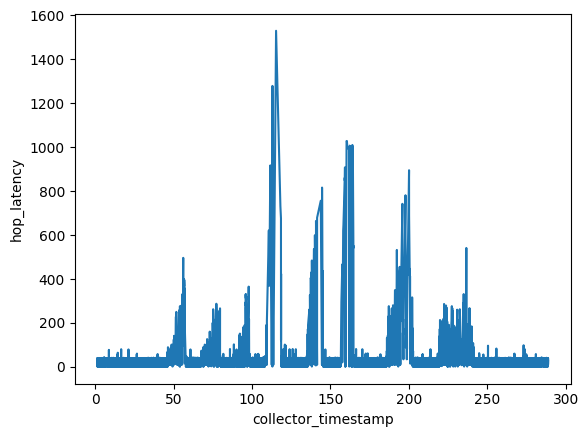

In [667]:
grouped_df = collector_df.groupby(by='flow_id').agg({'hop_latency': 'sum', 'collector_timestamp': 'first'})
sns.lineplot(data=grouped_df, x='collector_timestamp', y='hop_latency')


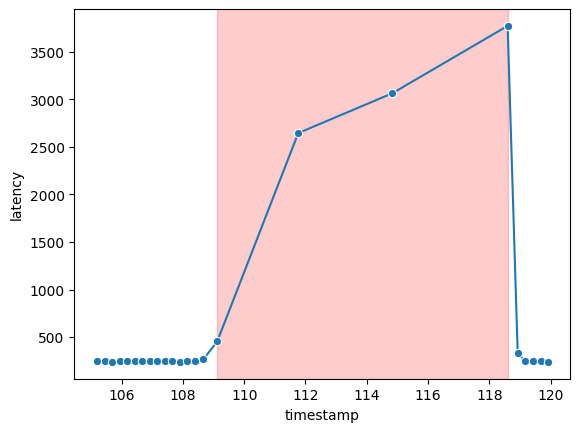

In [668]:
violation_ranges = compute_qos_violation_time_ranges(sender_df[(sender_df['timestamp'] > t[0]) & (sender_df['timestamp'] < t[1])], violation_threshold=400)
fig, ax = plt.subplots(1,1)
sns.lineplot(data=sender_df[(sender_df['timestamp'] > t[0]) & (sender_df['timestamp'] < t[1])], x='timestamp', y='latency', ax=ax, marker='o')
display_qos_violations(violation_ranges, ax)

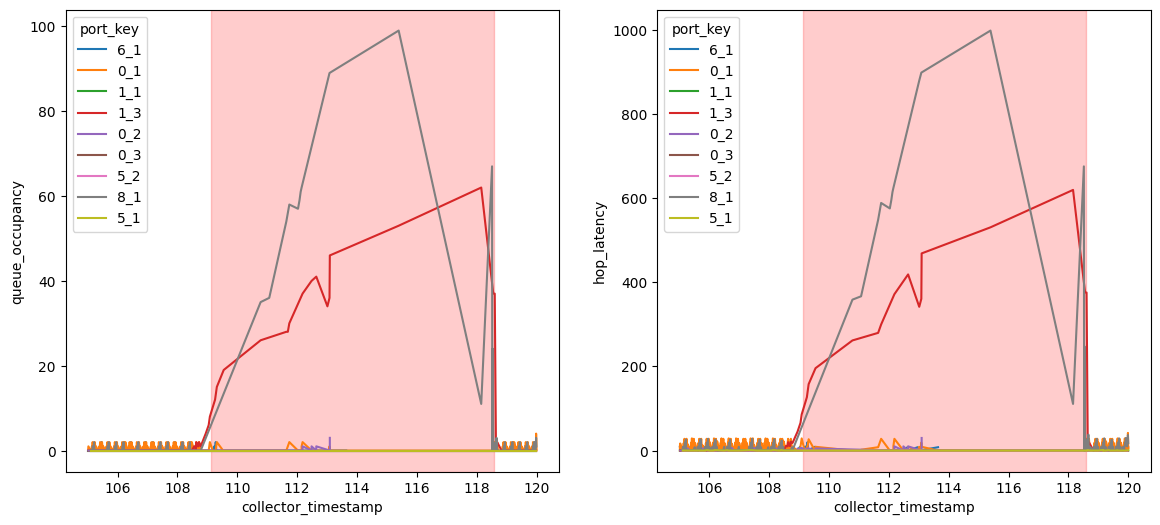

In [669]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
N = len(collector_df)
sns.lineplot(ax=ax[0], data=collector_df[(collector_df['collector_timestamp'] > t[0]) & (collector_df['collector_timestamp'] < t[1])], x='collector_timestamp', y='queue_occupancy', hue='port_key', legend=True, estimator=None, n_boot=0)
sns.lineplot(ax=ax[1], data=collector_df[(collector_df['collector_timestamp'] > t[0]) & (collector_df['collector_timestamp'] < t[1])], x='collector_timestamp', y='hop_latency', hue='port_key', legend=True, estimator=None, n_boot=0)
display_qos_violations(violation_ranges, ax[0], padding=0)
display_qos_violations(violation_ranges, ax[1], padding=0)

<Axes: xlabel='timestamp', ylabel='dropped'>

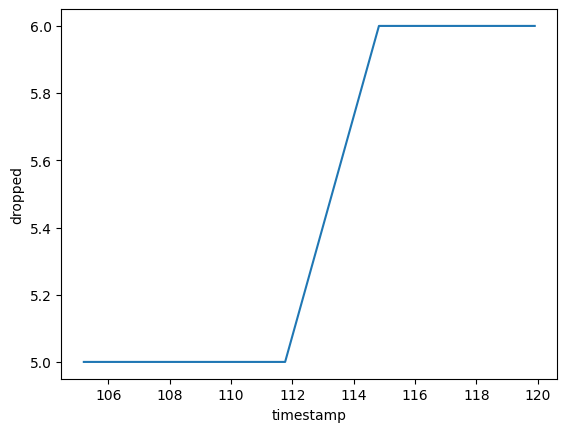

In [670]:
sns.lineplot(data=sender_df[(sender_df['timestamp'] > t[0]) & (sender_df['timestamp'] < t[1])], x='timestamp', y='dropped')

In [671]:
cols = ['timestamp', 'averagePathLatency', 'onePercentileSlowestPathLatency', 'port_key', 'averageLatency',
        'onePercentileSlowestLatency', 'onePercentileLargestQueueFillState', 'averageQueueFillState', 'packets']
rows = []
import json
max_i = 2160
for i in range(max_i+1):
    with open(f'./../data/new_http_udp1/logs{i}.json', 'r') as f:
        data = json.load(f)
        base_row = [
            data['createdAt'] - start,
            data['windowMetrics']['averagePathLatencyMicroS'] / 1000,
            data['windowMetrics']['onePercentileSlowestPathLatencyMicroS'] / 1000,
        ]
        for dm in data['windowMetrics']['deviceMetrics']:
            for pm in dm['portMetrics']:
                row = [*base_row]
                port_key = f'{dm["deviceName"]}_{pm["toDevice"]}'
                row.extend([
                    port_key,
                    pm['averageLatencyMicroS'] / 1000,
                    pm['onePercentileSlowestLatencyMicroS'] / 1000,
                    pm['onePercentileLargestQueueFillState'],
                    pm['averageQueueFillState'],
                    pm['packets'],
                ])
                rows.append(row)

summary_df = pd.DataFrame.from_records(rows, columns=cols)
summary_df.head()

,timestamp,averagePathLatency,onePercentileSlowestPathLatency,port_key,averageLatency,onePercentileSlowestLatency,onePercentileLargestQueueFillState,averageQueueFillState,packets
0,33.620061,23.068,44.382,r1_r7,8.218,29.641,2,0,351
1,33.620061,23.068,44.382,r1_tree-worker10,0.784,5.527,0,0,156
2,33.620061,23.068,44.382,r1_tree-worker4,0.405,1.181,0,0,89
3,33.620061,23.068,44.382,r7_r1,0.457,0.963,0,0,125
4,33.620061,23.068,44.382,r7_r10,0.733,1.437,0,0,167


In [672]:
# t=(170, 230)

<Axes: xlabel='timestamp', ylabel='onePercentileSlowestPathLatency'>

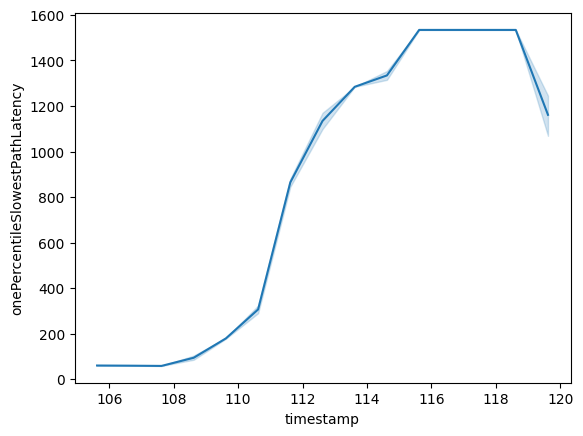

In [673]:
sns.lineplot(data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1])], x='timestamp', y='onePercentileSlowestPathLatency')

<Axes: xlabel='timestamp', ylabel='latency'>

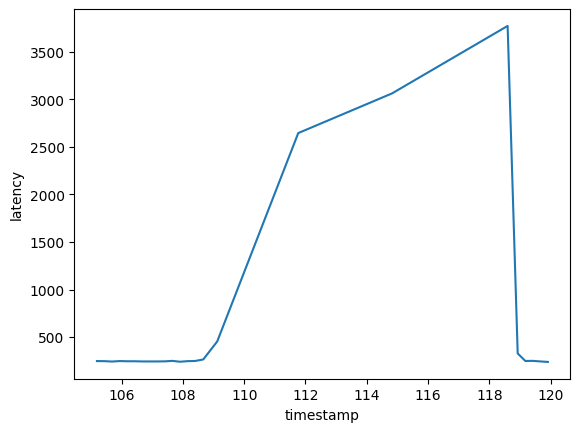

In [674]:
sns.lineplot(data=sender_df[(sender_df['timestamp'] > t[0]) & (sender_df['timestamp'] < t[1])], x='timestamp', y='latency')

<Axes: xlabel='timestamp', ylabel='averageLatency'>

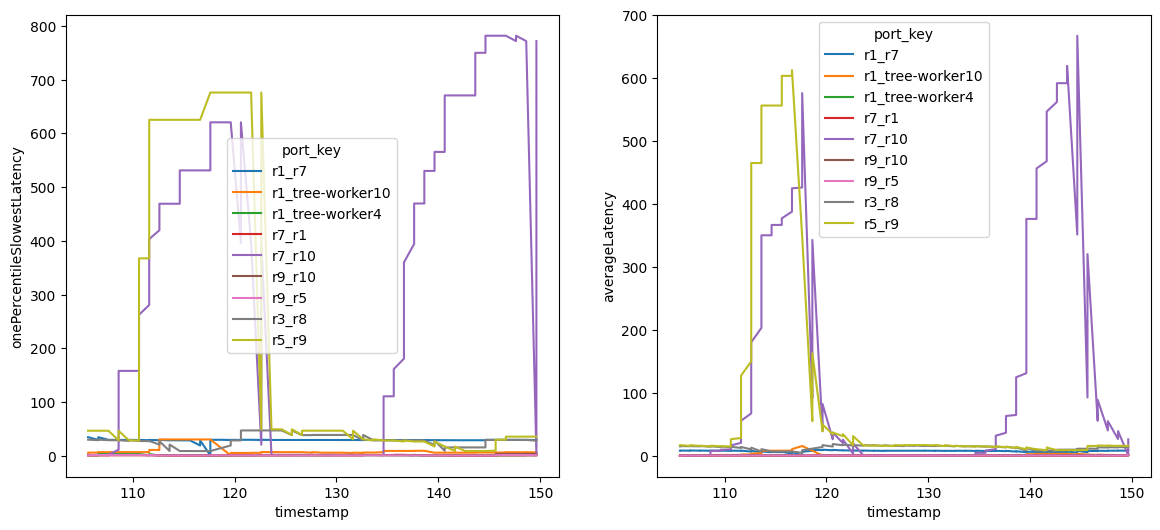

In [675]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
N = len(collector_df)
sns.lineplot(ax=ax[0], data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1] + 30)], x='timestamp', y='onePercentileSlowestLatency', hue='port_key', legend=True, estimator=None, n_boot=0)
sns.lineplot(ax=ax[1], data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1] + 30)], x='timestamp', y='averageLatency', hue='port_key', legend=True, estimator=None, n_boot=0)

<Axes: xlabel='timestamp', ylabel='averageQueueFillState'>

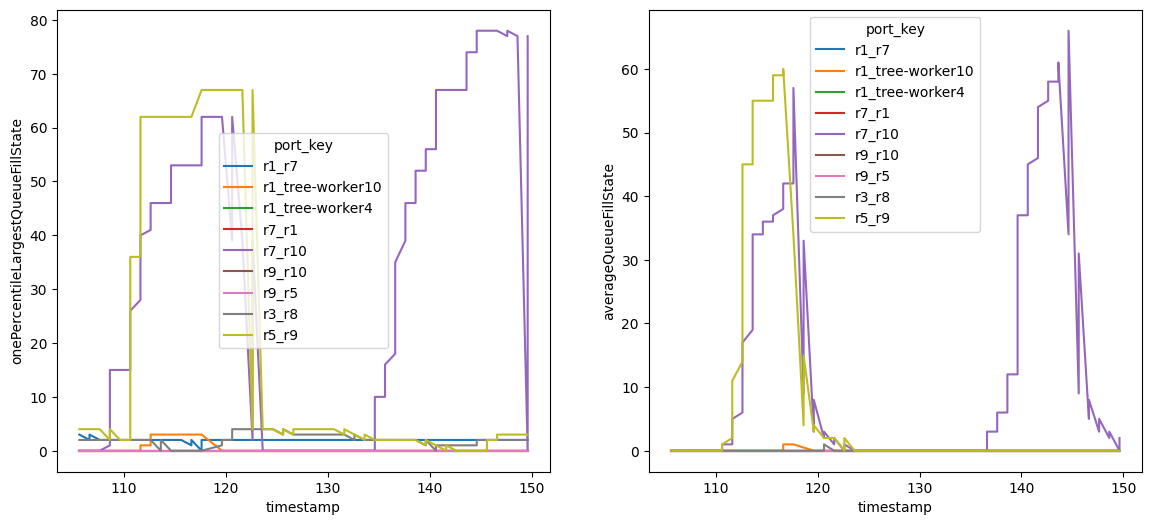

In [676]:
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
N = len(collector_df)
sns.lineplot(ax=ax[0], data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1] + 30)], x='timestamp', y='onePercentileLargestQueueFillState', hue='port_key', legend=True, estimator=None, n_boot=0)
sns.lineplot(ax=ax[1], data=summary_df[(summary_df['timestamp'] > t[0]) & (summary_df['timestamp'] < t[1] + 30)], x='timestamp', y='averageQueueFillState', hue='port_key', legend=True, estimator=None, n_boot=0)